In [1147]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import geopandas as gpd
# from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [1148]:
data_dir = './data/'

# Default matplotlib plot sizes
fig_x = 30
fig_y = 40

In [1149]:
#
# Global warming: monthly temperature anomaly
# The combined land-surface air and sea-surface water temperature anomaly is given as the deviation from the 1951 - 1980 mean.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Temperature+anomaly&Long-run+series%3F=false
#

#
# Global warming: monthly sea surface temperature anomaly
# This is measured at a nominal depth of 20cm, and given relative to the average temperature from the period of 1961 - 1990.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Sea+surface+temperature+anomaly&Long-run+series%3F=false
#

df1 = pd.read_csv(data_dir + 'climate-change-air.csv', low_memory=False)
df1.drop(df1[df1.Entity != 'World'].index, inplace=True)
df1.drop(columns=['Code', 'Entity'], inplace=True)
df1.rename(columns={'temperature_anomaly': 'world_air_temperature_anomaly'}, inplace=True)

df2 = pd.read_csv(data_dir + 'climate-change-sea.csv', low_memory=False)
df2.drop(df2[df2.Entity != 'World'].index, inplace=True)
df2.drop(columns=['Code', 'Entity'], inplace=True)
df2.rename(columns={'monthly_sea_surface_temperature_anomaly': 'world_sea_temperature_anomaly'}, inplace=True)

df = df1.merge(df2, on="Day", how = 'inner')
print(df.head())
print(df.shape[0])

          Day  world_air_temperature_anomaly  world_sea_temperature_anomaly
0  1880-01-15                          -0.18                        -0.2283
1  1880-02-15                          -0.24                        -0.1353
2  1880-03-15                          -0.08                        -0.0102
3  1880-04-15                          -0.16                        -0.1158
4  1880-05-15                          -0.09                        -0.3387
1701


In [1150]:
df.tail()

,Day,world_air_temperature_anomaly,world_sea_temperature_anomaly
1696,2021-05-15,0.79,0.6427
1697,2021-06-15,0.85,0.6351
1698,2021-07-15,0.92,0.7302
1699,2021-08-15,0.82,0.7160
1700,2021-09-15,0.92,0.7132


In [1151]:
orig_x_axis = df['Day']

In [1152]:
future_x_axis = orig_x_axis.append(pd.Series(['2021-10-15']))

In [1153]:
df.drop(columns=['world_sea_temperature_anomaly'], inplace=True)

# It is safe to drop dates since they are all evenly spaced
df.drop(columns=['Day'], inplace=True)

# To keep dates must use the following (and adjust rest of code)
#df['Day'] =  pd.to_numeric(pd.to_datetime(df['Day'], format='%Y-%m-%d'))

df.head()

,world_air_temperature_anomaly
0,-0.18
1,-0.24
2,-0.08
3,-0.16
4,-0.09


# _**Climate Change Time-Series Forecast**_
### Prepare the data

In [1157]:
#
# Create the dataset
#
dataset = df.values
dataset = dataset.astype('float32')


#
# Create numpy dataset
# reshape into X=t and Y=t+1
#
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
     
    for i in range(len(dataset) - look_back - 1):  # -1
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


#
# Normalize the dataset with scikit-learn MinMaxScaler
#
numpy.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [1158]:
#
# Split into train and test sets: 70%, 30%
#
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


#
# Reshape into X=t and Y=t+lookback
#
look_back = 1
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [1159]:
# Currently the data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 
# We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:
#
# Reshape input to be [samples, time steps, features]
#

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [1160]:
#
# Get last dataset entry to make one future prediction
#
def get_last_dataset_entry():
    last_entry = df.values[len(df.values)-1]
    last_entry = last_entry.astype('float32')
    last_entry = numpy.reshape(last_entry, (1,1,1))
    return last_entry

last_entry = get_last_dataset_entry()

## **Create the non-stacked LSTM model**

In [1161]:
#
# Create LSTM model #1 (unstacked)
#

def create_nonstacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):
    model = Sequential([
        LSTM(10, input_shape=(1, look_back), name='layer1'),
        Dense(1, name='Output')
    ])
    
    opt = Adam(learning_rate=lrate)
    
    model.compile(loss=loss_type, optimizer=opt, metrics=['accuracy'])
    
    model.summary()
    
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir='./tensorboard/nonstacked_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )

    history = model.fit(
        trainX,
        trainY,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=(testX, testY),
        callbacks = [tensorboard]
    )
    
    return history, model

## **Create the non-stacked LSTM model**

In [1162]:
#
# Create LSTM model #2 - stacked
#

def create_stacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):
    
    model = Sequential([
        LSTM(10, return_sequences=True, input_shape=(trainX.shape[1],1), name='layer1'),
        # Dropout(0.2),
        LSTM(20, return_sequences=False, name='layer2'),
        # Dropout(0.2),
        Dense(1, name='Output')
    ])

    opt = Adam(learning_rate=lrate)
    
    model.compile(loss=loss_type, optimizer=opt, metrics=['accuracy'])
    
    model.summary()
    
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir='./tensorboard/stacked_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )
    
    history = model.fit(
        trainX,
        trainY,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=(testX, testY),
        callbacks = [tensorboard]
    )

    return history, model

In [1163]:
#
# Run non-stacked model version
#


lrate = 0.0001
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'

history_nonstacked_lstm, lstm_nonstacked_model = create_nonstacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, 200, look_back, batch_size)

lstm_nonstacked_model.save('./models/lstm_nonstacked_model_1')
    
#
# Predictions
#
trainPredict = lstm_nonstacked_model.predict(trainX)
testPredict = lstm_nonstacked_model.predict(testX)
    
#
# Make next time period prediction
#
future_prediction = lstm_nonstacked_model.predict(last_entry)
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_nonstacked_lstm = lstm_nonstacked_model.evaluate(testX, testY, verbose=1)
print("Model Score:")
print(score_nonstacked_lstm)
#print('Loss: {}'.format(score_nonstacked_lstm[0]))
#print('Accuracy: {}'.format(score_nonstacked_lstm[1]*100))

Model: "sequential_211"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1188/1188 [==============================] - 3s 1ms/step - loss: 0.0331 - accuracy: 8.4175e-04 - val_loss: 0.0833 - val_accuracy: 0.0000e+00
Epoch 2/200
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0051 - accuracy: 8.4175e-04 - val_loss: 0.0509 - val_accuracy: 0.0000e+00
Epoch 3/200
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0046 - accuracy: 8.4175e-04 - val_loss: 0.0471 - val_accuracy: 0.

INFO:tensorflow:Assets written to: ./models/lstm_nonstacked_model_1/assets


INFO:tensorflow:Assets written to: ./models/lstm_nonstacked_model_1/assets


Future Prediction unscaled: [[1.0268816]]

Train Score: 0.11 RMSE
Test Score: 0.16 RMSE
16/16 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 0.0020
Model Score:
[0.005086786113679409, 0.0019646366126835346]


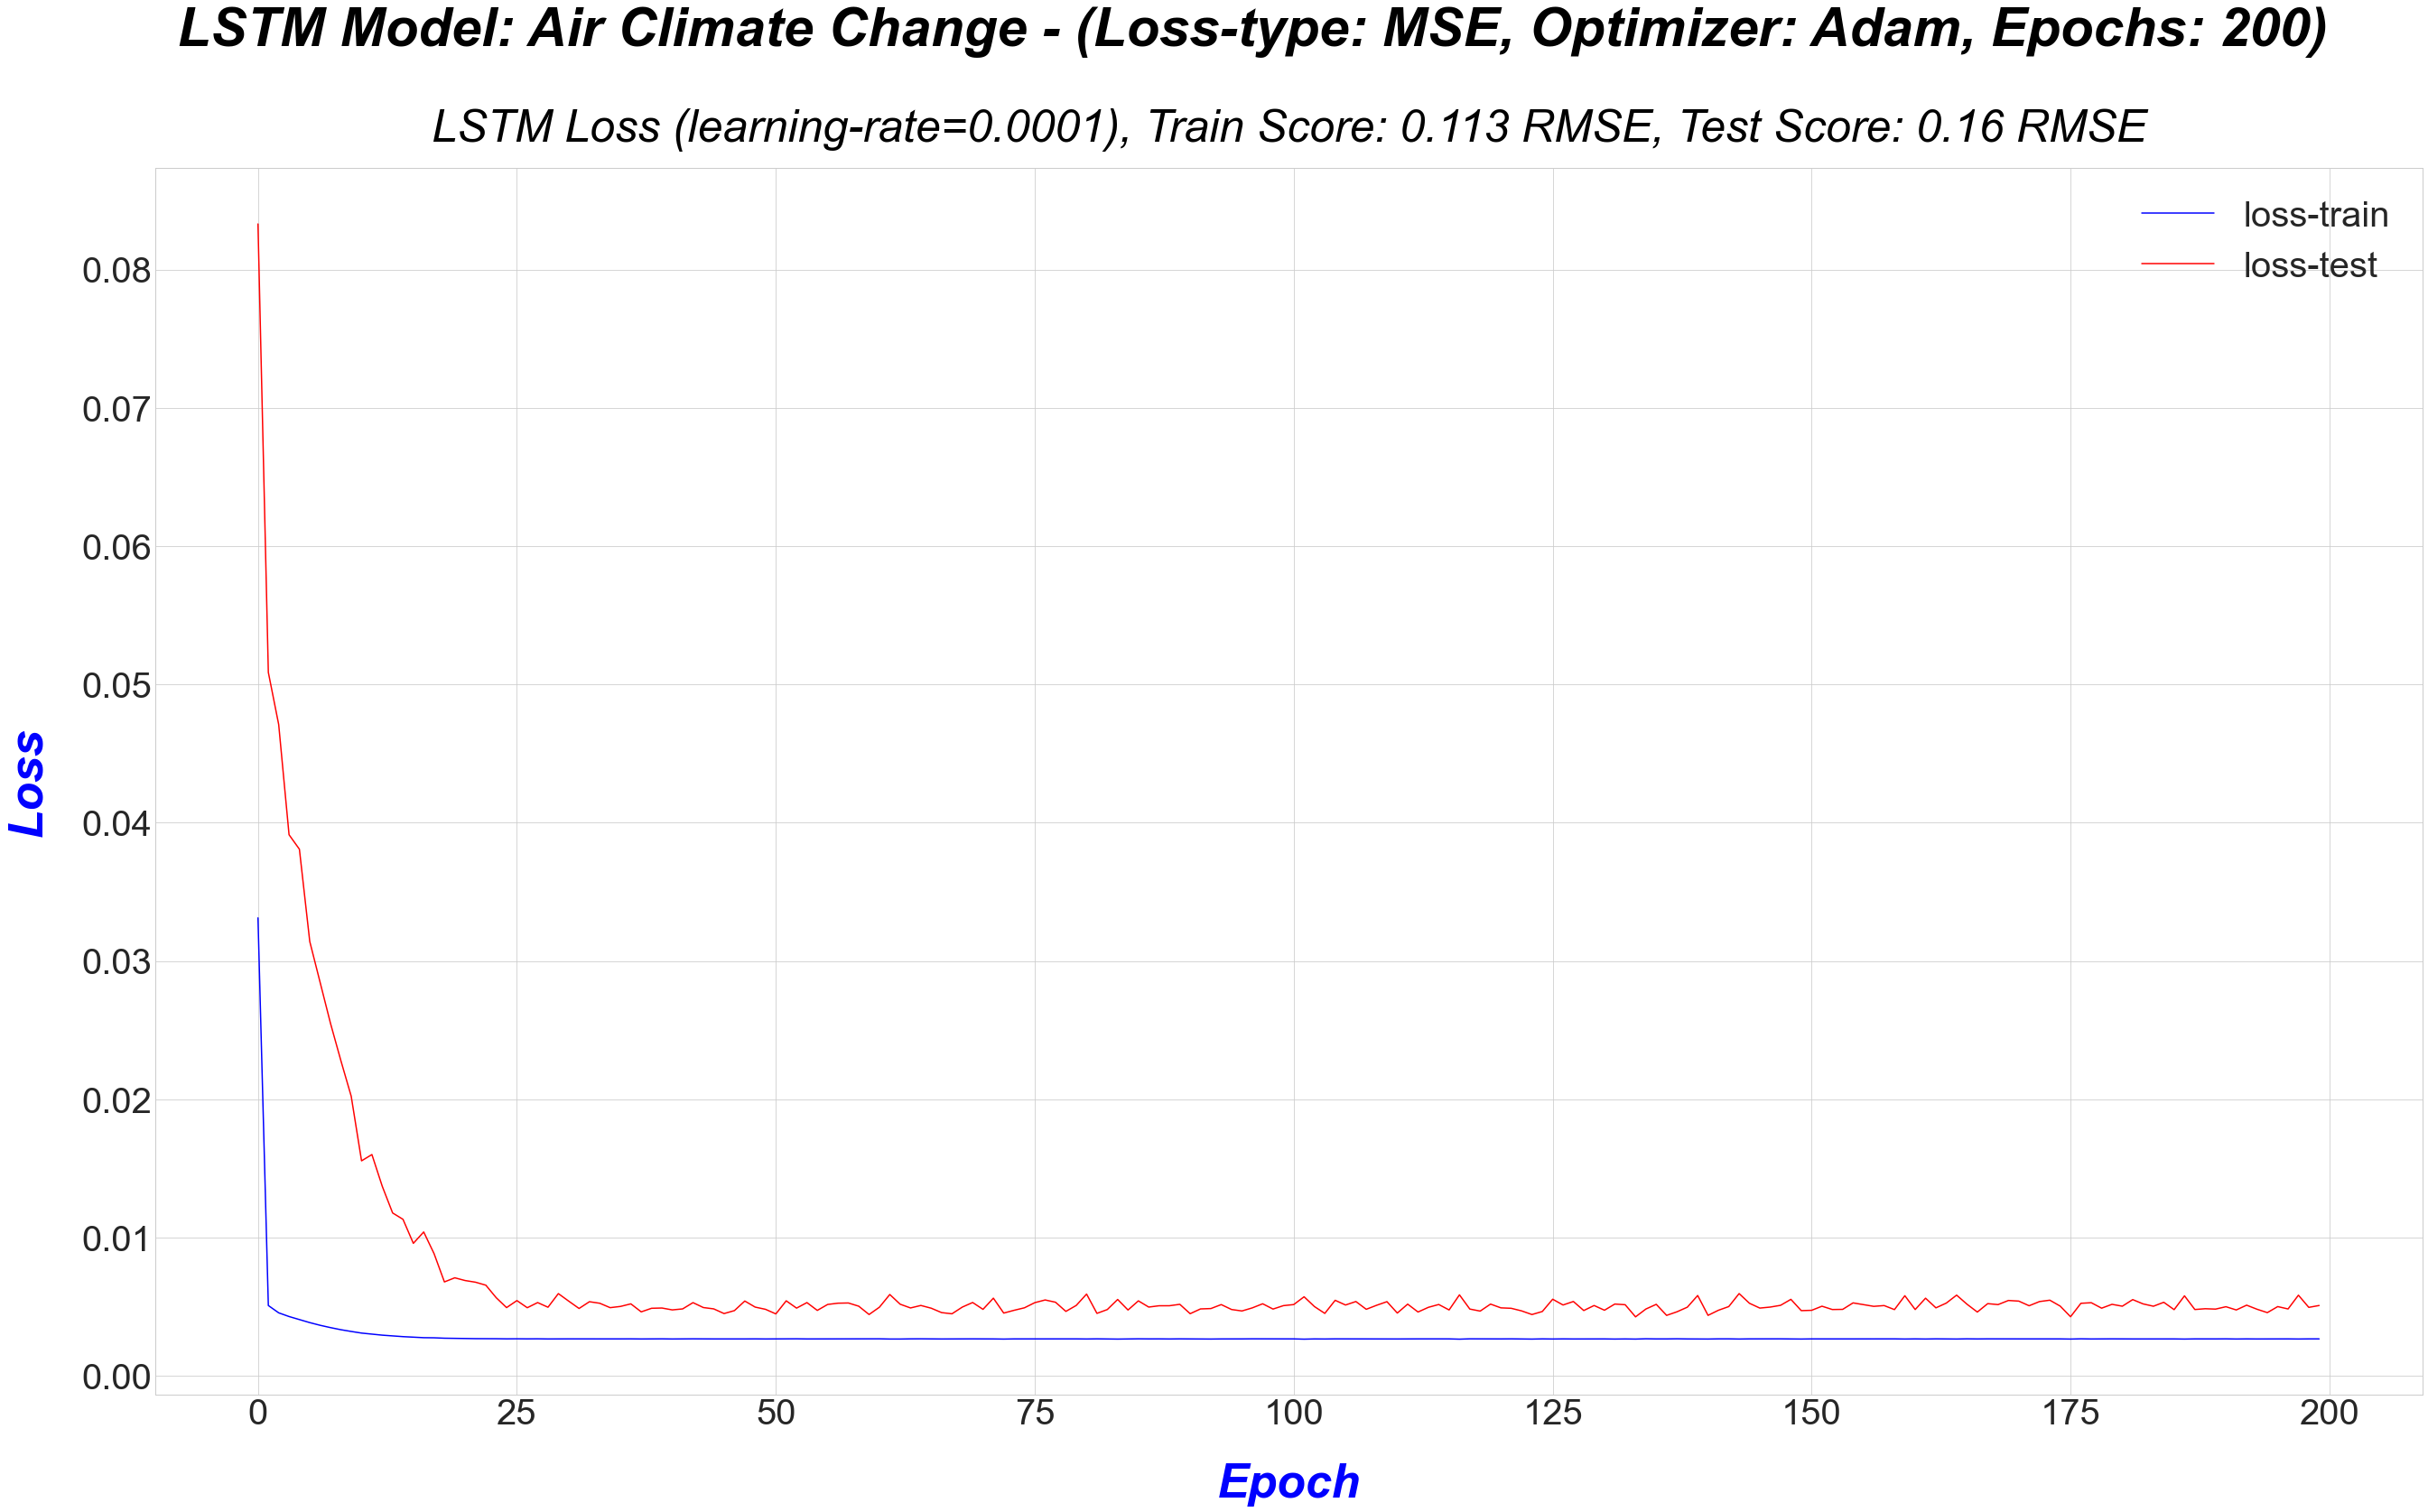

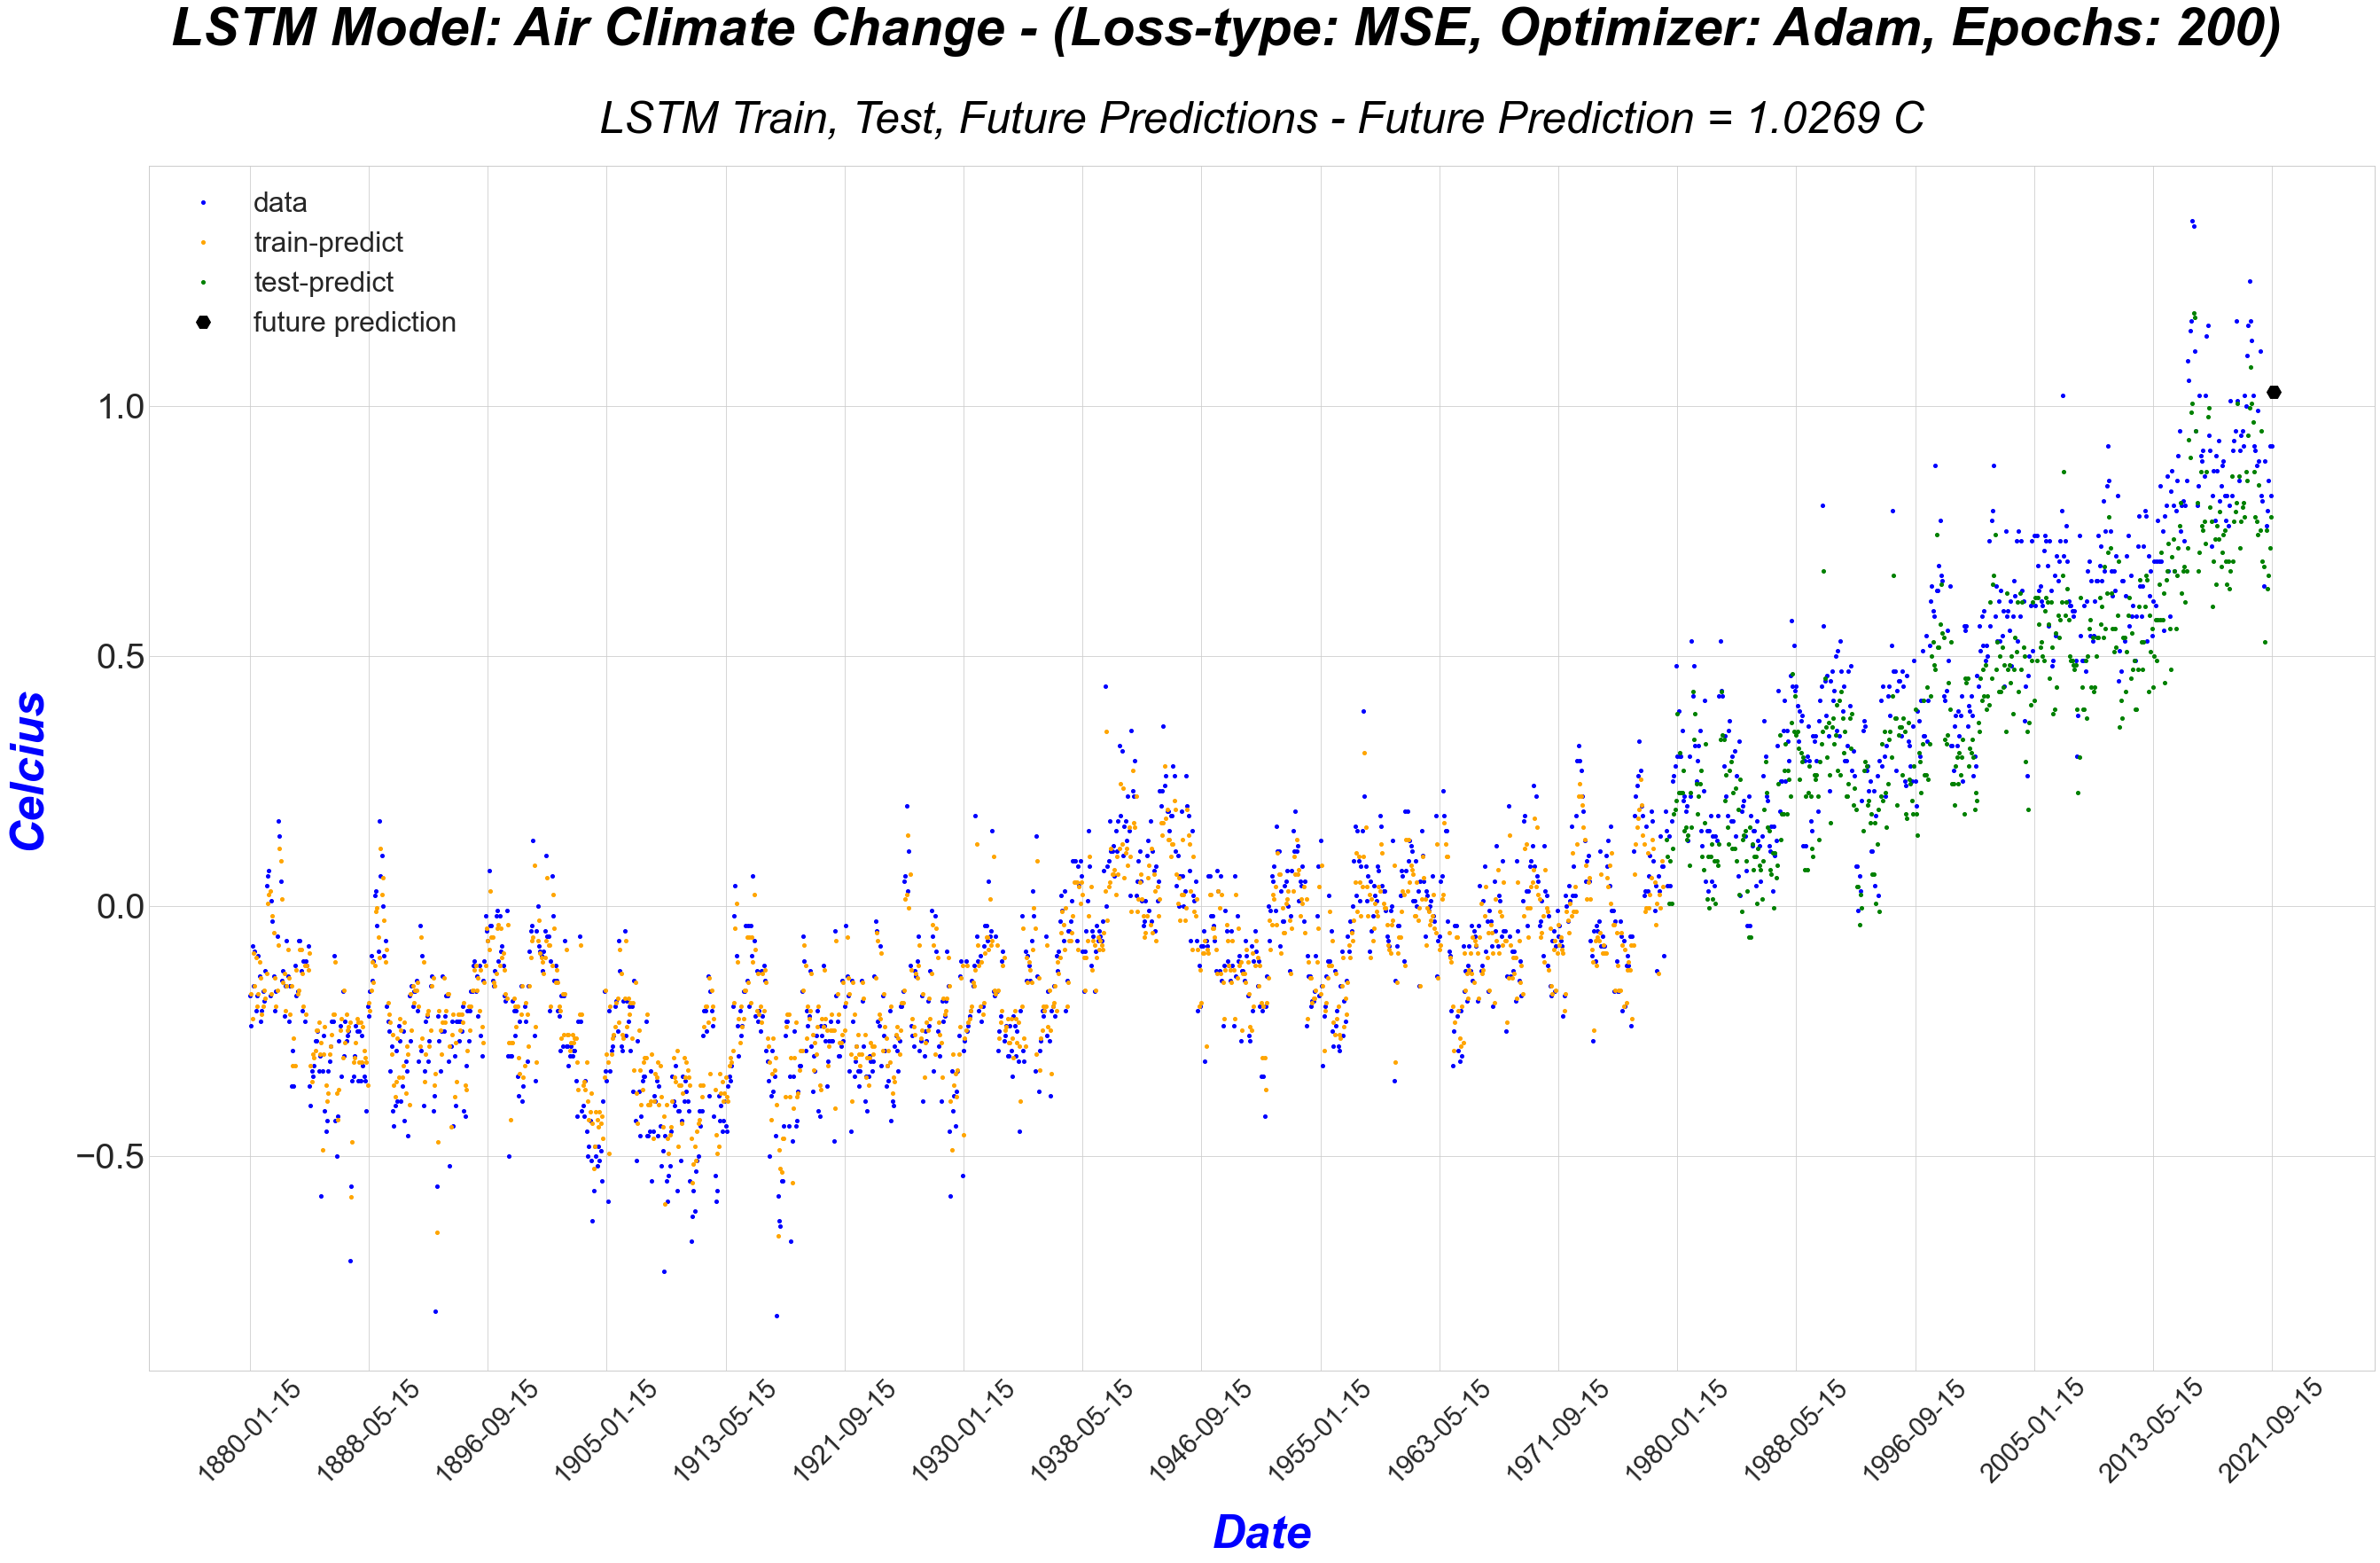

In [1164]:
#
# Plot for non-stacked model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
futurePredictPlot = numpy.empty_like(dataset)
futurePredictPlot[:, :] = numpy.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_nonstacked_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history_nonstacked_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_nonstacked_lstm.history['val_loss'], "r", label='loss-test')

plt.suptitle('LSTM Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 200)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.grid(True)

plt.savefig("./images/lstm-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=4, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=4, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=4, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=16, label='future prediction')

plt.suptitle('LSTM Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 200)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

plt.grid(True)

plt.savefig("./images/lstm-plot.png")
plt.show();

In [1165]:
#
# Stacked layer LSTM
#

lrate = 0.0001
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'

history_stacked_lstm, lstm_stacked_model = create_stacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, 200, look_back, 1)
lstm_stacked_model.save('./models/lstm_stacked_model_1')
    
#
# Predictions
#
trainPredict = lstm_stacked_model.predict(trainX)
testPredict = lstm_stacked_model.predict(testX)
    
#
# Make next time period prediction
#
future_prediction = lstm_stacked_model.predict(last_entry)
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


score_stacked_lstm = lstm_stacked_model.evaluate(testX, testY, verbose=1)
print("Stacked Model Score:")
print(score_stacked_lstm)
#print('Loss: {}'.format(score_stacked_lstm[0]))
#print('Accuracy: {}'.format(score_stacked_lstm[1]*100))

Model: "sequential_212"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 1, 10)             480       
                                                                 
 layer2 (LSTM)               (None, 20)                2480      
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 2,981
Trainable params: 2,981
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1188/1188 [==============================] - 4s 2ms/step - loss: 0.0364 - accuracy: 8.4175e-04 - val_loss: 0.0823 - val_accuracy: 0.0000e+00
Epoch 2/200
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0061 - accuracy: 8.4175e-04 - val_loss: 0.0687 - val_accuracy: 0.0000e+00
Epoch 3/

INFO:tensorflow:Assets written to: ./models/lstm_stacked_model_1/assets


INFO:tensorflow:Assets written to: ./models/lstm_stacked_model_1/assets


Future Prediction unscaled: [[1.0982571]]

Train Score: 0.11 RMSE
Test Score: 0.14 RMSE
16/16 [==============================] - 1s 1ms/step - loss: 0.0042 - accuracy: 0.0020
Stacked Model Score:
[0.00416316045448184, 0.0019646366126835346]


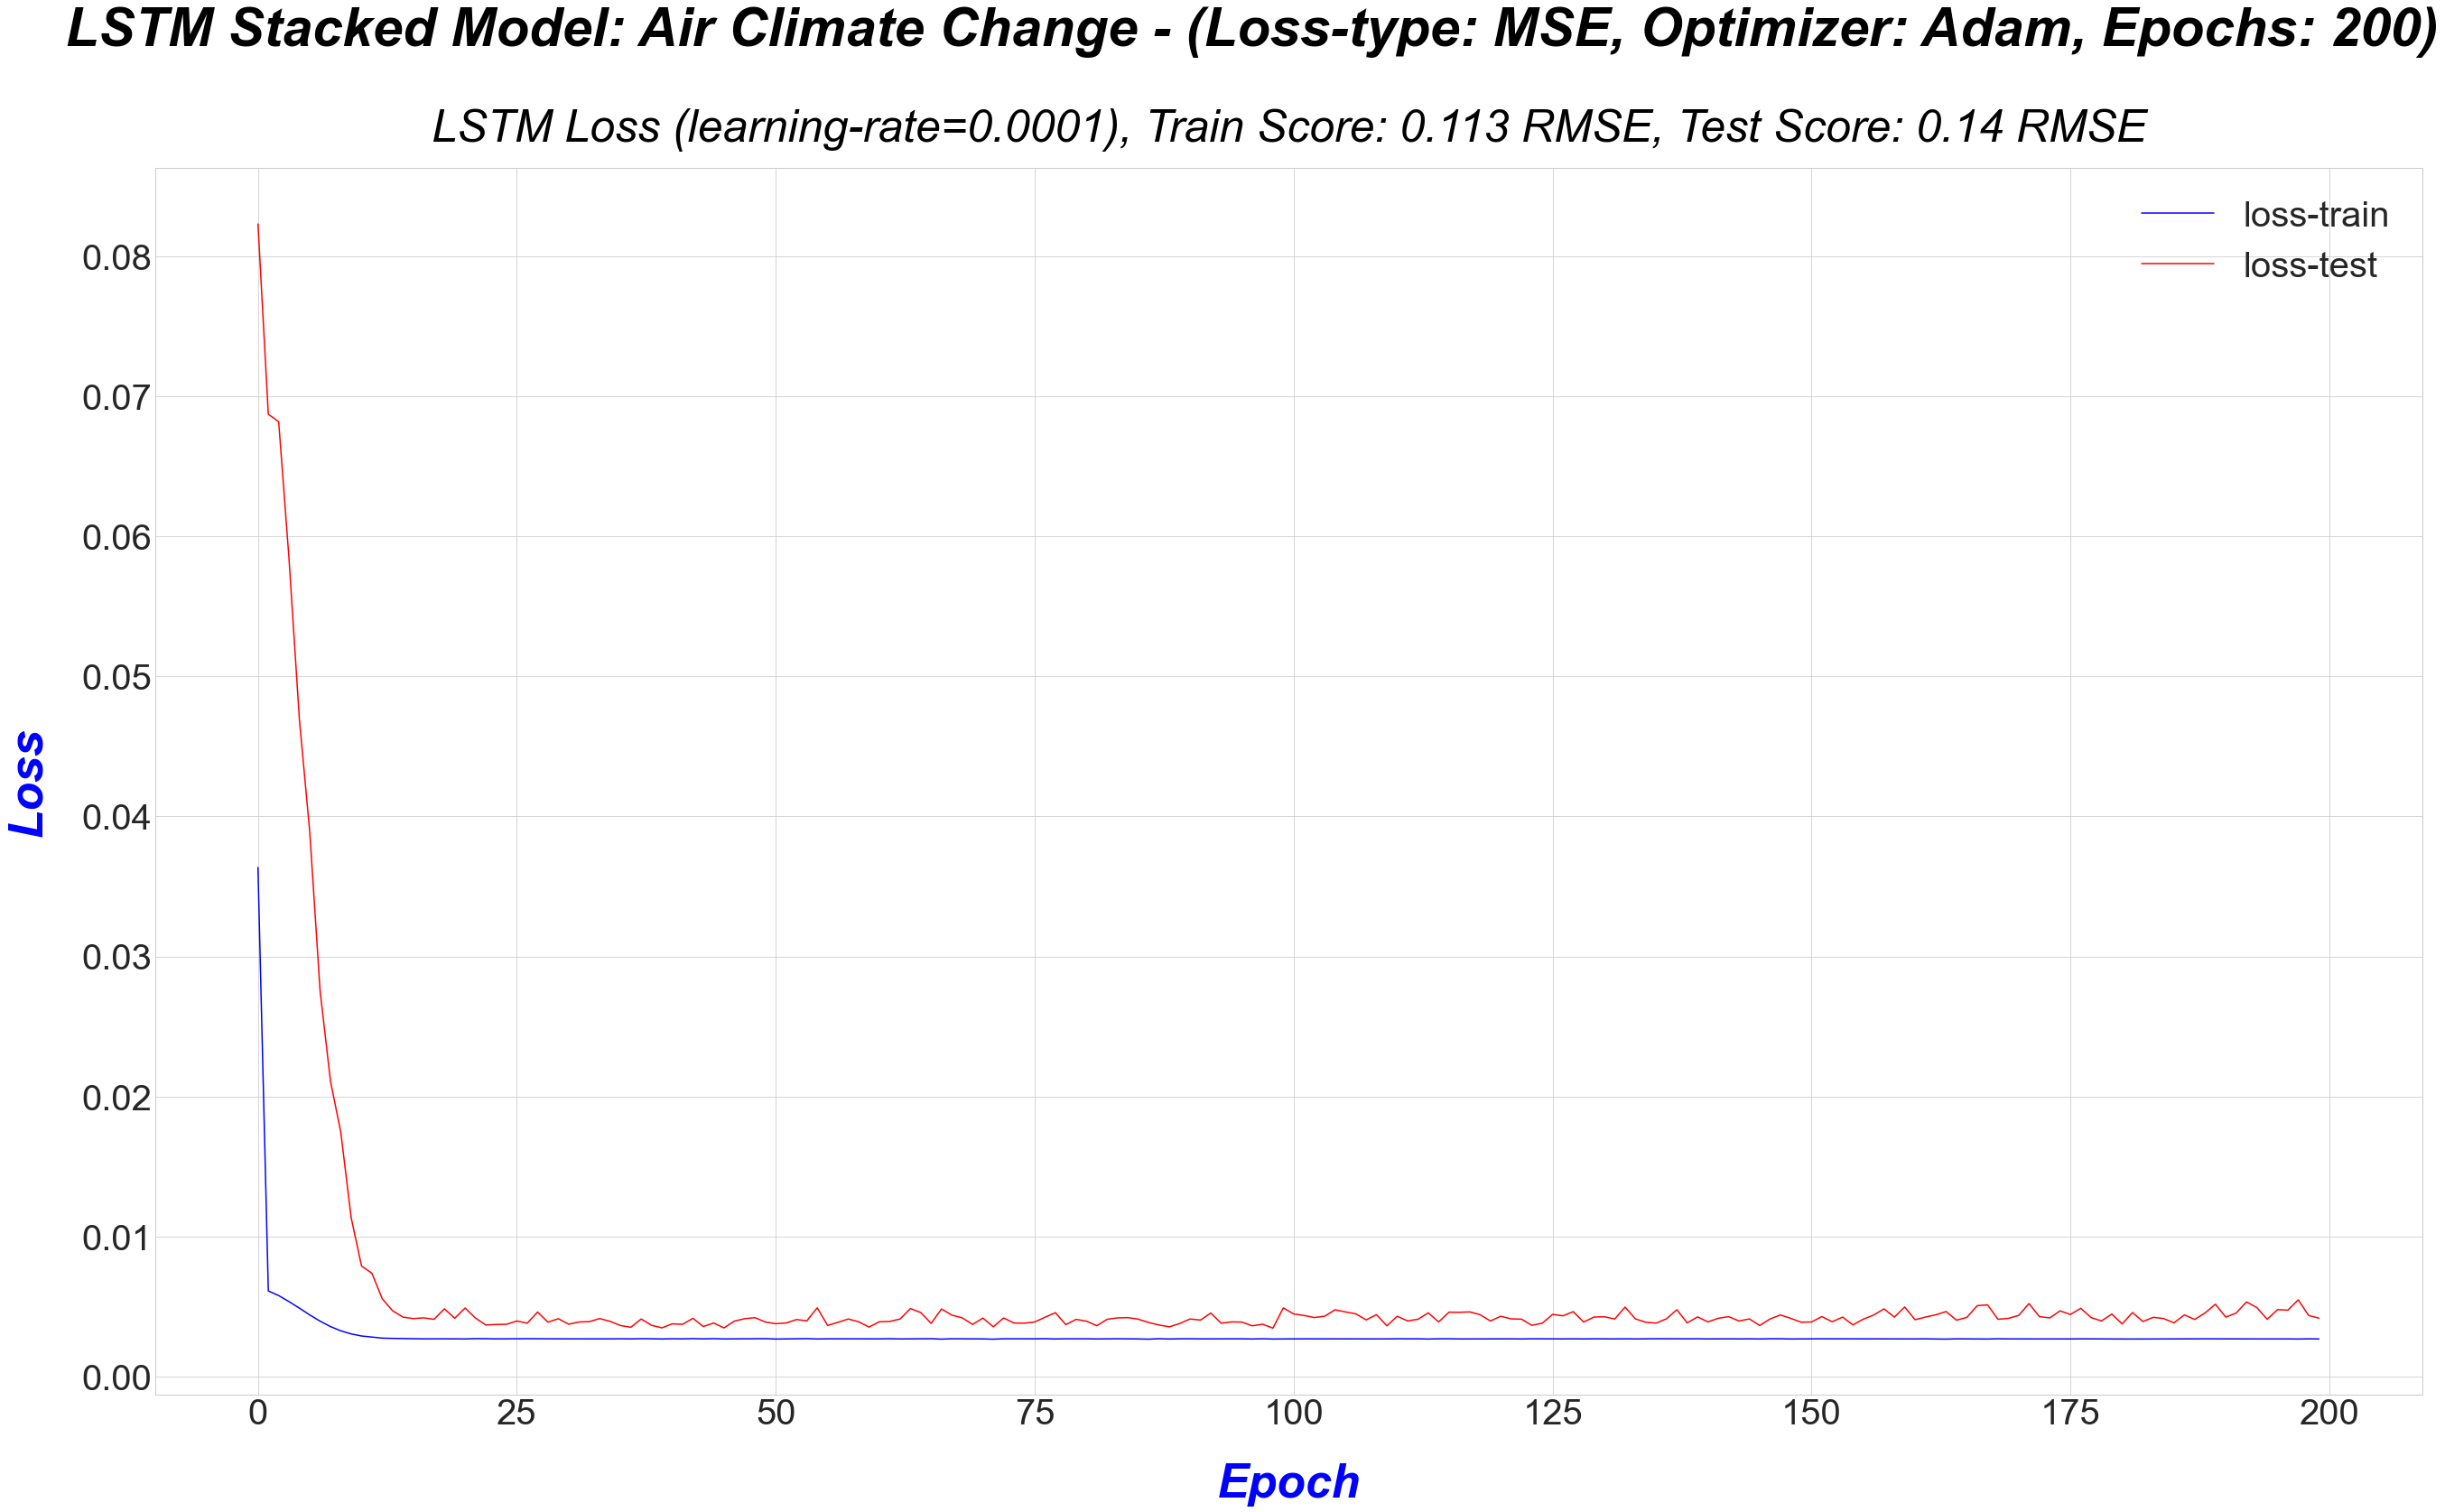

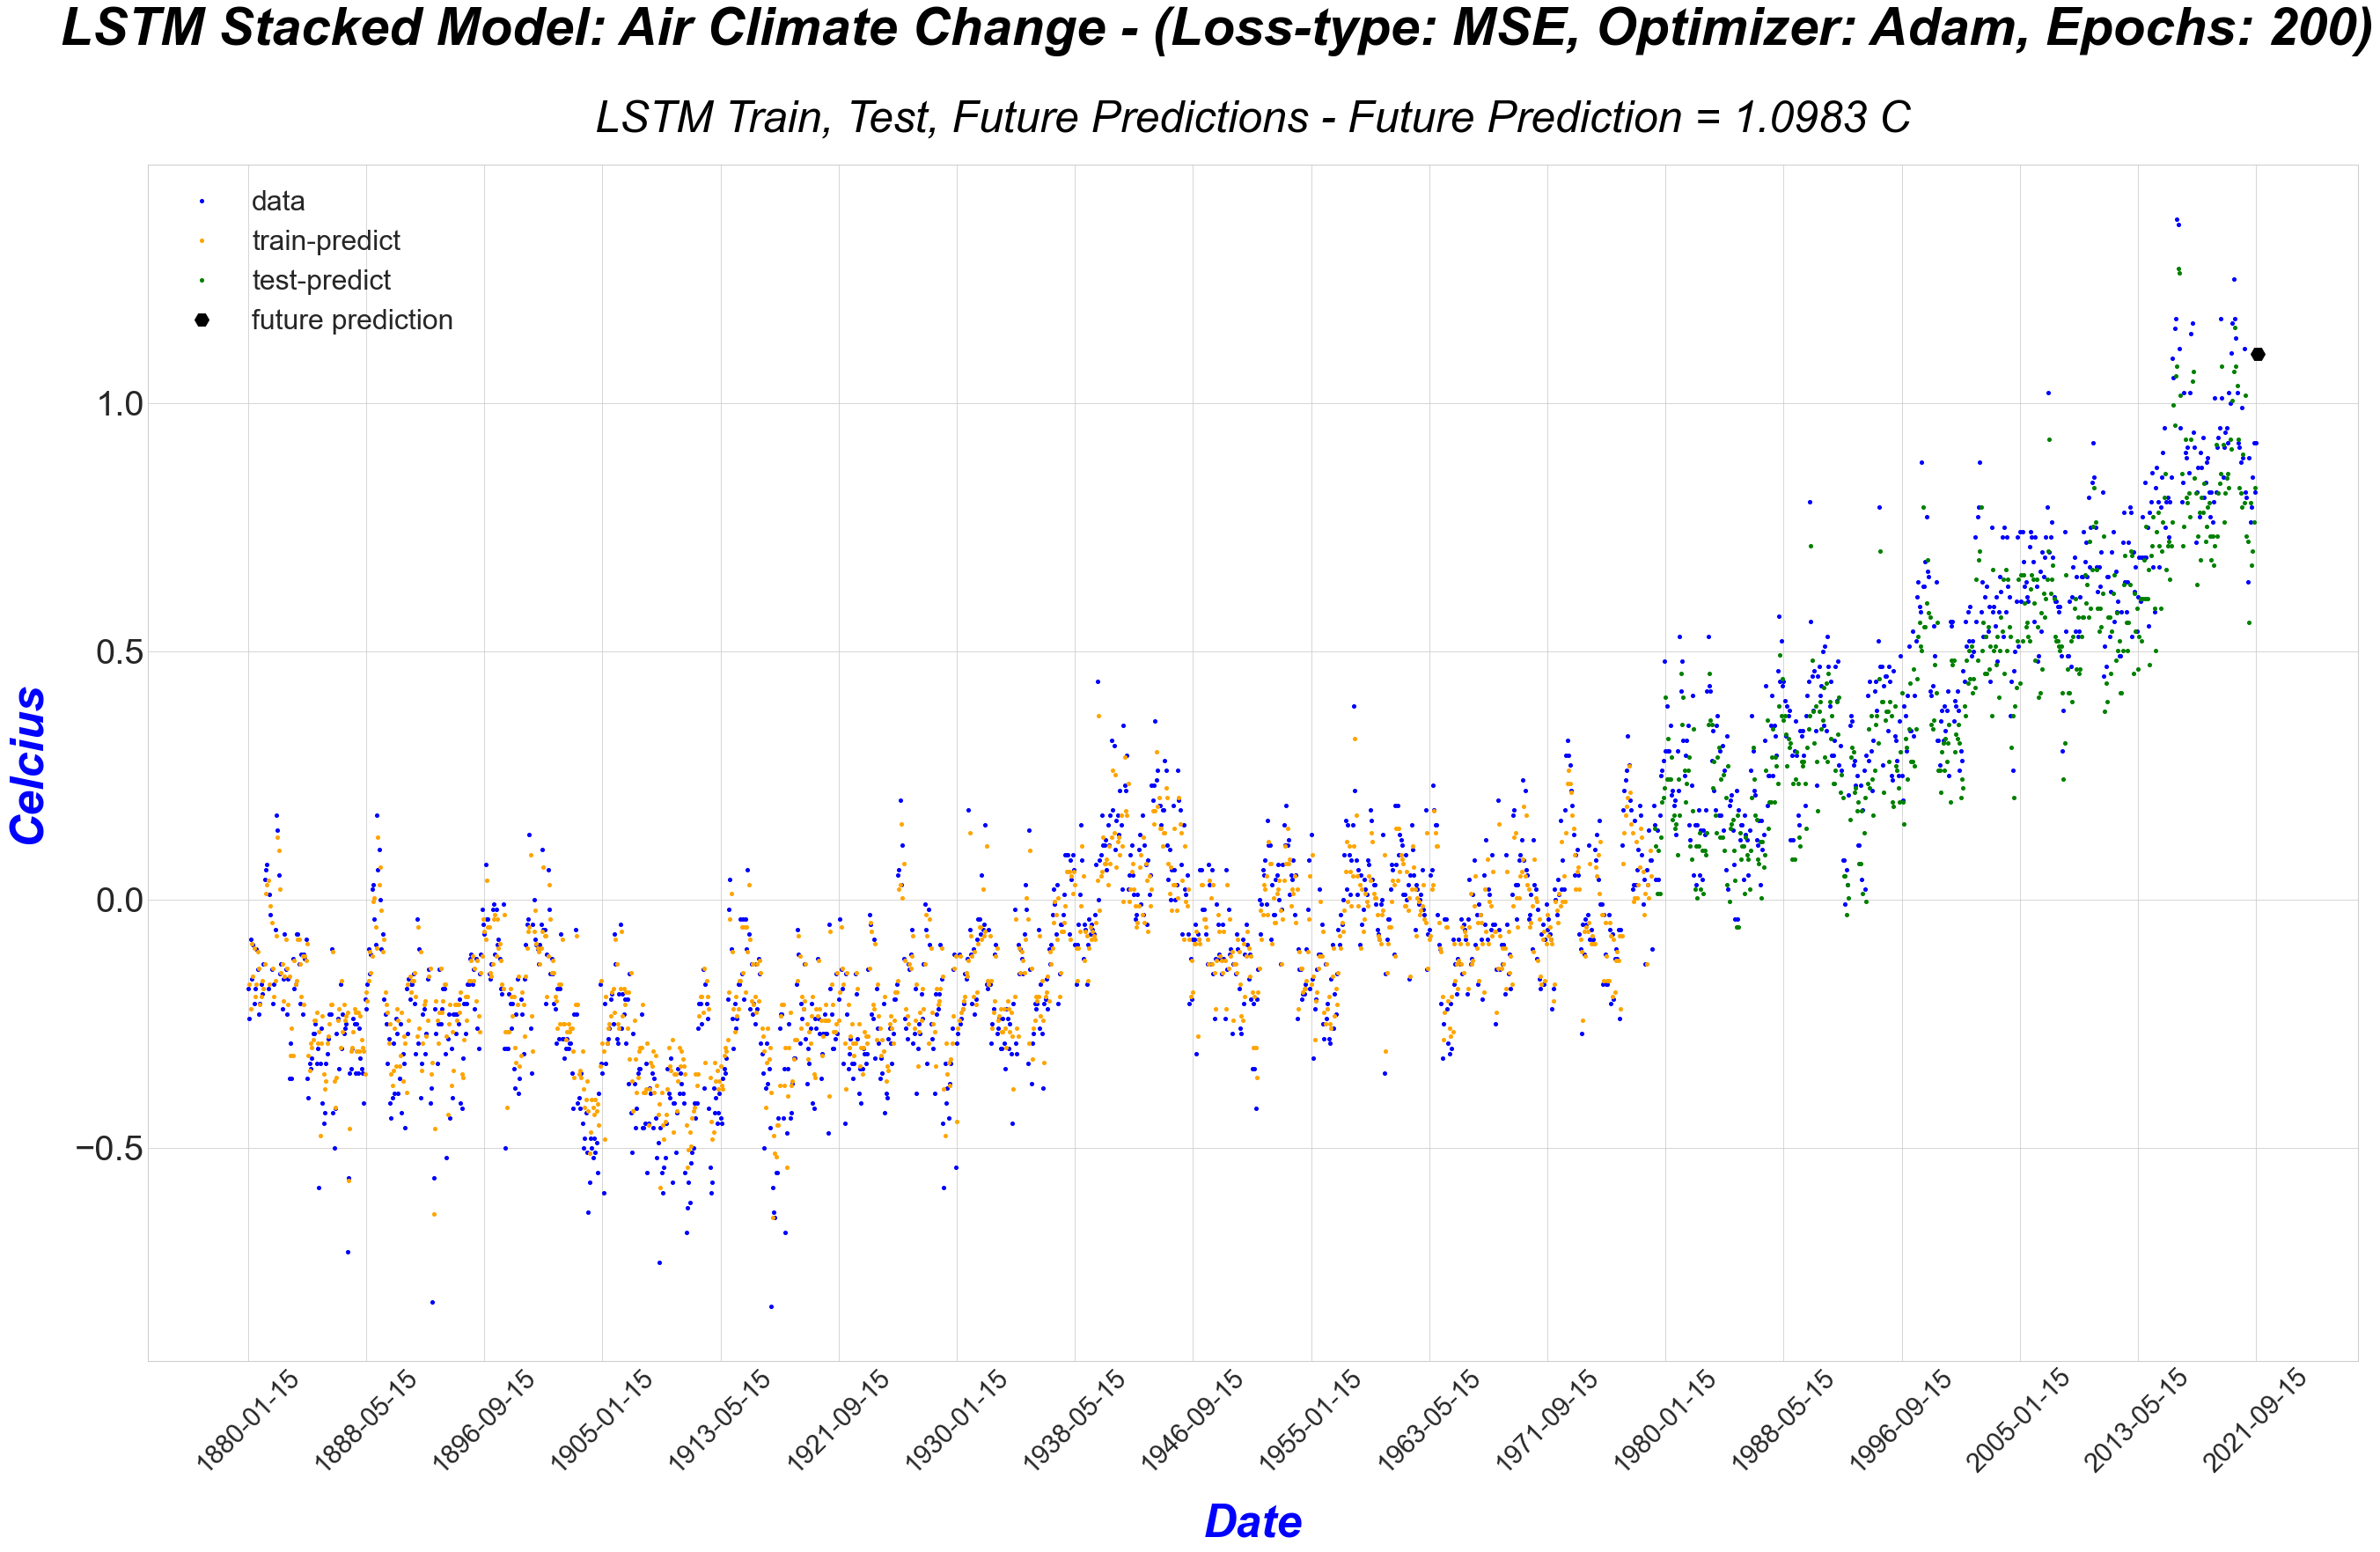

In [1166]:
#
# Plot for stacked LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
futurePredictPlot = numpy.empty_like(dataset)
futurePredictPlot[:, :] = numpy.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_stacked_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history_stacked_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_stacked_lstm.history['val_loss'], "r", label='loss-test')

plt.suptitle('LSTM Stacked Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 200)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-stacked-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=4, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=4, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=4, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=16, label='future prediction')

plt.suptitle('LSTM Stacked Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 200)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-stacked-plot.png")
plt.show();

### **Create Main Climate Change Dataframe**
#### Using all datasets

In [862]:
#
# Apply method for each dataset's dataframe
#
def update_master_df(row):
    
    global df_main
    
    if row['Country Code'] != 'WLD':
        return
    
    #country = row['Country Code']
    code = row['Indicator Code']
    
    d = []
    
    for y in range(1960, 2021, 1):
        if str(y) in row:
            d.append(row[str(y)])
        else:
            d.append(float("NaN"))
    
    df_main[code] = d

      

file_names = [
    'API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_3053855.csv',     # Access to electricity (% of population) EG.ELC.ACCS.ZS
    'API_AG.LND.AGRI.ZS_DS2_en_csv_v2_3052884.csv',     # Agricultural land (% of land area) AG.LND.AGRI.ZS
    'API_AG.LND.ARBL.ZS_DS2_en_csv_v2_3054826.csv',     # Arable land (% of land area) AG.LND.ARBL.ZS
    'API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3053008.csv',     # CO2 emissions (metric tons per capita) EN.ATM.CO2E.PC
    'API_AG.YLD.CREL.KG_DS2_en_csv_v2_3053734.csv',     # Cereal yield (kg per hectare) AG.YLD.CREL.KG
    'API_EG.USE.ELEC.KH.PC_DS2_en_csv_v2_3052822.csv',  # Electric power consumption (kWh per capita) EG.USE.ELEC.KH.PC
    'API_AG.LND.FRST.ZS_DS2_en_csv_v2_3052585.csv',     # Forest area (% of land area) AG.LND.FRST.ZS
    'API_AG.LND.EL5M.ZS_DS2_en_csv_v2_3057029.csv',     # Land area where elevation is below 5 meters (% of total land area) AG.LND.EL5M.ZS
    'API_SH.DYN.MORT_DS2_en_csv_v2_3058030.csv',        # Mortality rate, under-5 (per 1,000 live births) SH.DYN.MORT
    'API_SP.POP.GROW_DS2_en_csv_v2_3052790.csv',        # Population growth (annual %) SP.POP.GROW
    'API_EN.POP.EL5M.ZS_DS2_en_csv_v2_3057452.csv',     # Population living in areas where elevation is below 5 meters (% of total population) EN.POP.EL5M.ZS
    'API_SI.POV.DDAY_DS2_en_csv_v2_3055766.csv',        # Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population) SI.POV.DDAY
    'API_SE.PRM.CMPT.ZS_DS2_en_csv_v2_3053767.csv',     # Primary completion rate, total (% of relevant age group) SE.PRM.CMPT.ZS
    'API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_3053509.csv',     # Renewable energy consumption (% of total final energy consumption) EG.FEC.RNEW.ZS
    'API_SP.URB.TOTL_DS2_en_csv_v2_3058363.csv',        # Urban population SP.URB.TOTL
    'API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_3052981.csv',     # Agriculture, forestry, and fishing, value added (% of GDP) NV.AGR.TOTL.ZS
    'API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3052647.csv',     # CO2 emissions (kt) EN.ATM.CO2E.KT
    'API_EG.USE.PCAP.KG.OE_DS2_en_csv_v2_3052915.csv',  # Energy use (kg of oil equivalent per capita) EG.USE.PCAP.KG.OE
    'API_AG.LND.FRST.K2_DS2_en_csv_v2_3054052.csv',     # Forest area (sq. km) AG.LND.FRST.K2
    'API_EN.ATM.METH.KT.CE_DS2_en_csv_v2_3052859.csv',  # Methane emissions (kt of CO2 equivalent) EN.ATM.METH.KT.CE
    'API_EN.ATM.NOXE.KT.CE_DS2_en_csv_v2_3054894.csv',  # Nitrous oxide emissions (thousand metric tons of CO2 equivalent) EN.ATM.NOXE.KT.CE
    'API_EN.URB.MCTY.TL.ZS_DS2_en_csv_v2_3053950.csv',  # Population in urban agglomerations of more than 1 million (% of total population) EN.URB.MCTY.TL.ZS
    'API_SP.POP.TOTL_DS2_en_csv_v2_3052518.csv',        # Population, total SP.POP.TOTL
    'API_SH.STA.MALN.ZS_DS2_en_csv_v2_3058087.csv',     # Prevalence of underweight, weight for age (% of children under 5) SH.STA.MALN.ZS
    'API_EG.ELC.RNEW.ZS_DS2_en_csv_v2_3054878.csv',     # Renewable electricity output (% of total electricity output) EG.ELC.RNEW.ZS
    'API_SE.ENR.PRSC.FM.ZS_DS2_en_csv_v2_3057870.csv',  # School enrollment, primary and secondary (gross), gender parity index (GPI) SE.ENR.PRSC.FM.ZS
    'API_EN.ATM.GHGT.KT.CE_DS2_en_csv_v2_3052850.csv',  # Total greenhouse gas emissions (kt of CO2 equivalent) EN.ATM.GHGT.KT.CE
    'API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_3053985.csv'   # Urban population (% of total population) SP.URB.TOTL.IN.ZS
]


#
# Main dataframe to work off of
#

df_main = pd.DataFrame(columns=['year'])
df_main['year'] = [
    1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
    1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
    2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
    2020
]


#
# Loop through each dataset and add it to the main dataframe
#
c = 0
df_collection = {}
for f in file_names:
    _df = pd.read_csv(data_dir + f)
    _df.drop(columns=['Country Name', 'Indicator Name'], inplace=True)
    _df.drop(_df.columns[_df.columns.str.contains('unnamed', case = False)], axis = 1, inplace = True)
    df_collection[c] = _df
    _df.apply(update_master_df, axis=1)             
    c += 1

df_main.head(65)  

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1960,NaN,NaN,NaN,3.121158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.130853,3.032156e+09,NaN,NaN,NaN,NaN,33.617972
1,1961,NaN,35.965095,9.656792,3.068090,1428.405939,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.400146,3.071596e+09,NaN,NaN,NaN,NaN,34.115490
2,1962,NaN,36.044180,9.668757,3.114839,1518.828776,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.589890,3.124561e+09,NaN,NaN,NaN,NaN,34.557149
3,1963,NaN,36.146651,9.756626,3.221195,1583.640114,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.729545,3.189656e+09,NaN,NaN,NaN,NaN,34.943734
4,1964,NaN,36.236356,9.785195,3.324046,1585.371387,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.884439,3.255146e+09,NaN,NaN,NaN,NaN,35.336154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2016,87.714456,36.701221,10.764754,4.436759,4009.231276,NaN,30.716421,NaN,41.3,...,39958245.9,8068580.0,2934600.0,23.538567,7.424485e+09,13.732595,NaN,1.00006,44550150.0,54.370833
57,2017,88.602034,37.008413,10.831252,4.441309,4114.052902,NaN,NaN,NaN,40.0,...,NaN,8137390.0,2986520.0,23.765917,7.509410e+09,13.416059,NaN,0.99759,45117640.0,54.823831
58,2018,89.419014,36.903521,10.825170,4.483524,4070.667048,NaN,NaN,NaN,38.8,...,NaN,8174420.0,2984340.0,24.008219,7.592476e+09,13.133182,NaN,0.98576,45873850.0,55.271710
59,2019,90.084031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,...,NaN,NaN,NaN,24.216891,7.673345e+09,12.864292,NaN,0.98637,NaN,55.714433
